In [ ]:


import numpy as np
import pandas as pd



**Summary**

The project aims to classify images into "Fake" and "Real" categories using the VGG19 model and transfer learning on the CIFAKE Dataset.
The steps followed in the project can be summarized as follows:

Dataset Preparation: The project utilized a dataset containing images of both real and fake images. The dataset was split into training and testing sets.For convenience I have trained on 4000 images and tested on 400 images.

Model Architecture: The VGG16 model, pre-trained on the ImageNet dataset, was used as the base model. The last few layers were modified to suit the binary classification task. A fully connected layer with a sigmoid activation function was added as the output layer.

Model Training: The model was compiled with appropriate loss and optimization functions. Data augmentation techniques such as rescaling, shearing, zooming, and horizontal flipping were applied to the training data to improve model generalization. The model was trained on the augmented training data.

Model Evaluation: The trained model was evaluated on the testing data. Predictions were made on the test set, and performance metrics such as accuracy, confusion matrix, classification report, and mean average precision (mAP) were calculated to assess the model's performance.

Visualization: Various visualizations were created to understand the model's predictions better. These included a confusion matrix, loss plot, precision-recall curve, and F1 curve. Additionally, a sample of test images was selected randomly to display the predicted labels and class probabilities.

The project aimed to develop a model that can accurately classify images as either "Fake" or "Real" based on transfer learning from the VGG16 model. The evaluation metrics and visualizations provided insights into the model's performance and its ability to distinguish between real and fake images.

**References**:

*Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.*

*Bird, J.J., Lotfi, A. (2023). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv preprint arXiv:2303.14126.*

*Real images are from Krizhevsky & Hinton (2009), fake images are from Bird & Lotfi (2023). The Bird & Lotfi study is a preprint currently available on ArXiv and this description will be updated when the paper is published.**

Creating a train and test dataset from the CIFAKE dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/archive (5).zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [ ]:
import os
import random
import shutil

# Set the paths to your dataset folders
dataset_dir = "/content/drive/MyDrive/Dataset/archive (5).zip"
real_dir = os.path.join(dataset_dir, "REAL")
fake_dir = os.path.join(dataset_dir, "FAKE")

In [ ]:
dataset_dir

'/content/drive/MyDrive/Dataset/archive (5).zip'

In [ ]:
real_dir

'/content/drive/MyDrive/Dataset/archive (5).zip/REAL'

In [ ]:
 #Set the paths to the new directories that will contain the selected images
train_dir = "/content/train"
real_train_dir = os.path.join(train_dir, "REAL")
fake_train_dir = os.path.join(train_dir, "FAKE")


In [ ]:
# Create the new directories if they don't exist
if not os.path.exists(real_train_dir):
    os.makedirs(real_train_dir)
if not os.path.exists(fake_train_dir):
    os.makedirs(fake_train_dir)

In [ ]:
# Set the number of images to select from each folder
num_images = 5000

In [ ]:
test_dir = "/content/test"
real_test_dir = os.path.join(test_dir, "REAL")
fake_test_dir = os.path.join(test_dir, "FAKE")

# Create the new directories if they don't exist
if not os.path.exists(real_test_dir):
    os.makedirs(real_test_dir)
if not os.path.exists(fake_test_dir):
    os.makedirs(fake_test_dir)

# Set the number of images to select from each folder
num_images = 200


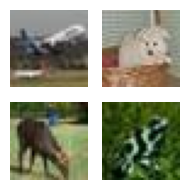

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace these with the paths to your four image files
image_paths = ['train/REAL/4998.jpg', 'train/REAL/4999 (6).jpg', 'train/REAL/4500 (5).jpg', 'train/REAL/4500 (7).jpg']

# Create a 2x2 grid for displaying the images
fig, axes = plt.subplots(2, 2, figsize=(2, 2))

# Loop through the images and display them in the grid
for i in range(4):
    row = i // 2
    col = i % 2
    img = mpimg.imread(image_paths[i])
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()


Model creation and Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Set the paths to the train and test directories
train_dir = "/content/train"
test_dir ="/content/test"

# Set up the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size=16

# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load the training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32,32),
                                                    batch_size=batch_size, class_mode='binary')

# Train the model
history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=10)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)
# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


80134624/80134624 [==============================] - 0s 0us/step
Found 100000 images belonging to 2 classes.
Epoch 1/10
6250/6250 [==============================] - 145s 22ms/step - loss: 0.4938 - accuracy: 0.7588
Epoch 2/10
6250/6250 [==============================] - 132s 21ms/step - loss: 0.4481 - accuracy: 0.7906
Epoch 3/10
6250/6250 [==============================] - 132s 21ms/step - loss: 0.4318 - accuracy: 0.8012
Epoch 4/10
6250/6250 [==============================] - 131s 21ms/step - loss: 0.4224 - accuracy: 0.8059
Epoch 5/10
6250/6250 [==============================] - 135s 22ms/step - loss: 0.4134 - accuracy: 0.8120
Epoch 6/10
6250/6250 [==============================] - 132s 21ms/step - loss: 0.4082 - accuracy: 0.8137
Epoch 7/10
6250/6250 [==============================] - 132s 21ms/step - loss: 0.4034 - accuracy: 0.8164
Epoch 8/10
6250/6250 [==============================] - 129s 21ms/step - loss: 0.3987 - accuracy: 0.8195
Epoch 9/10
6250/6250 [=============================

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Set the paths to the train and test directories
train_dir = "/content/train"
test_dir ="/content/test"

# Set up the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size=16

# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load the training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32,32),
                                                    batch_size=batch_size, class_mode='binary')
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Found 100000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20155969 (76.89 MB)
Trainable params: 131585 (514.00 KB)
Non-trai

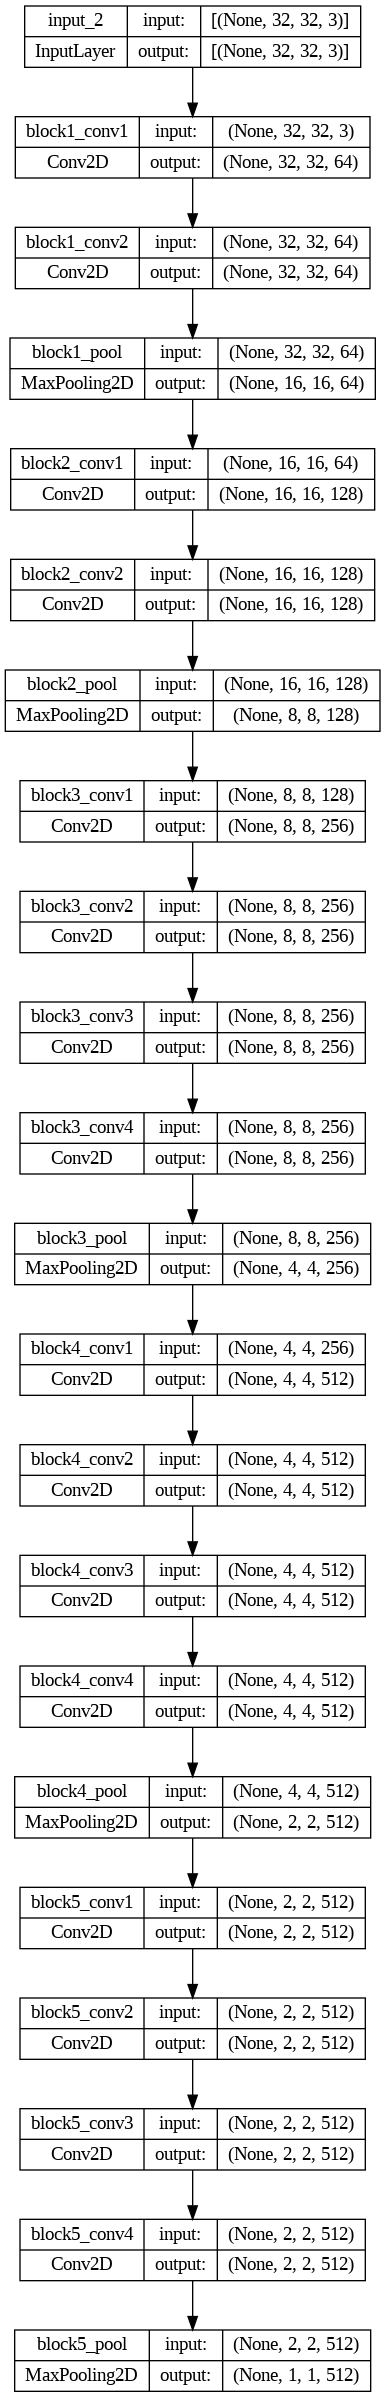

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the VGG19 base
plot_model(base_model, to_file='vgg19_base.png', show_shapes=False, show_layer_names=True)


NameError: ignored

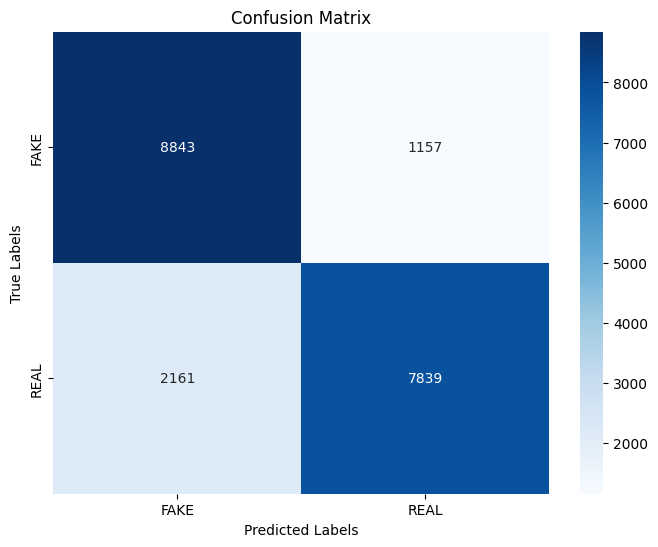

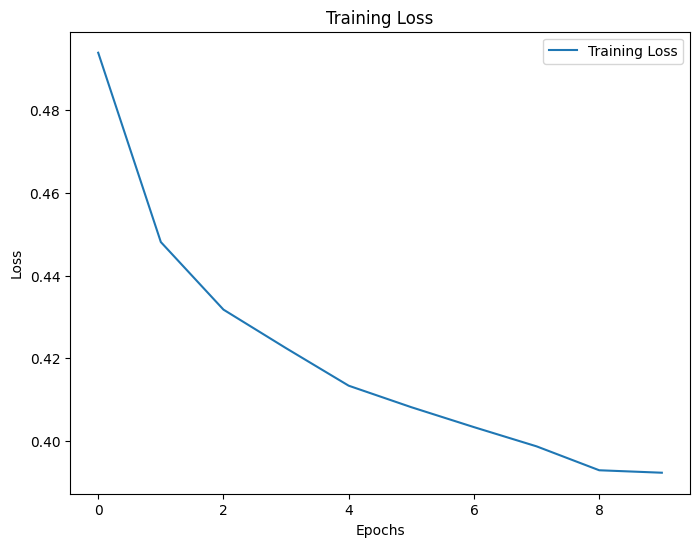

In [ ]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

**Result Visualisation**

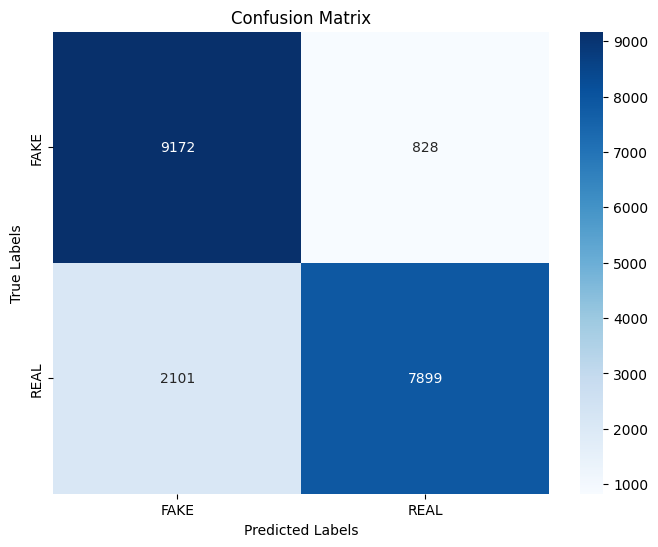

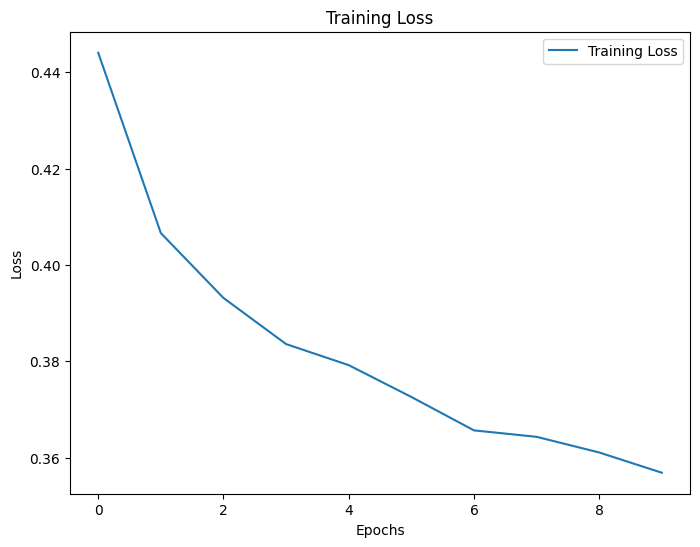

In [ ]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


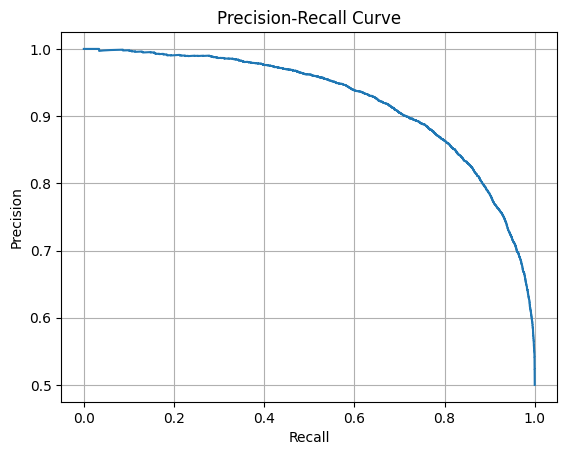

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(test_generator.labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


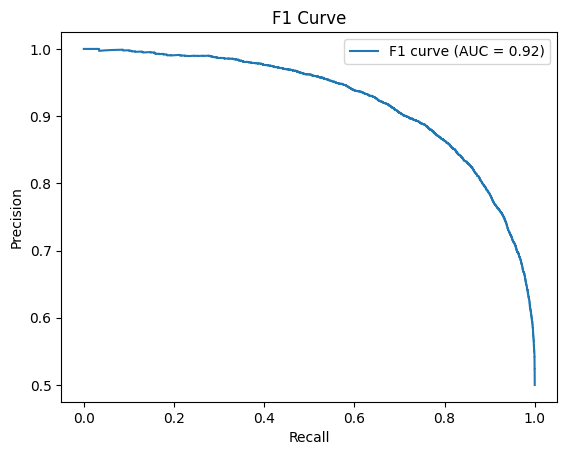

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(test_generator.labels, predictions)

# Calculate F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Calculate area under the curve (AUC)
auc_score = auc(recall, precision)

# Plot the F1 curve
plt.plot(recall, precision, label='F1 curve (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('F1 Curve')
plt.legend()
plt.show()


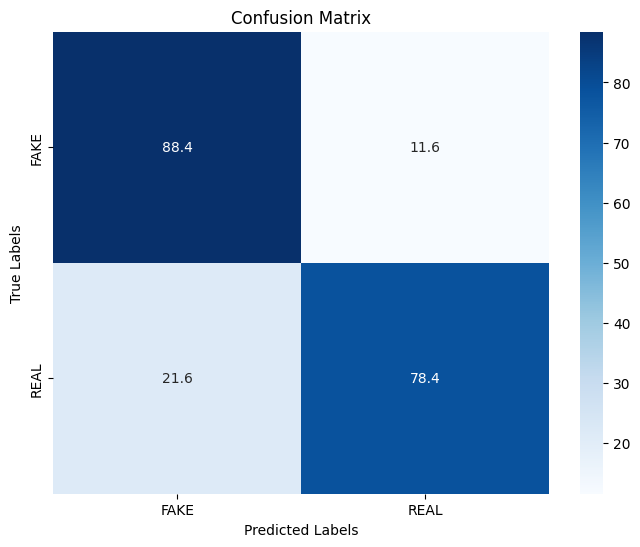

In [ ]:


# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


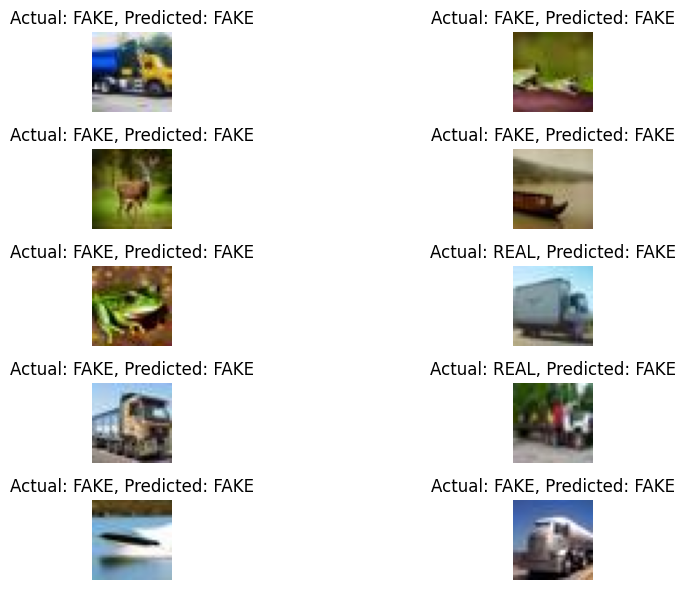

In [ ]:


# Select random samples from the test data
sample_indices = np.random.choice(len(test_generator), size=10, replace=False)
sample_images = []
sample_actual_labels = []
sample_predicted_labels = []
sample_probabilities = []

for i in sample_indices:
    image, actual_labels = test_generator[i]
    predicted_label = labels[i]
    probability = predictions[i][0]
    sample_images.append(image[0])  # Access the first image in the batch
    sample_actual_labels.append(actual_labels[0])  # Access the actual label for the first image
    sample_predicted_labels.append(predicted_label)
    sample_probabilities.append(probability)

# Calculate the subplot layout based on the number of sample images
num_images = len(sample_images)
num_rows = int(np.ceil(num_images / 2))
num_cols = min(num_images, 2)

# Plot the sample images with labels and probabilities
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(sample_images[i])
    actual_label = "FAKE" if sample_actual_labels[i] == 0 else "REAL"
    predicted_label = "FAKE" if sample_predicted_labels[i] == 0 else "REAL"
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Set the paths to the train and test directories
train_dir = "/content/train"
test_dir ="/content/test"

# Set up the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size=16

# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Load the training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32,32),
                                                    batch_size=batch_size, class_mode='binary')

# Train the model
history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=50)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)
# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Found 100000 images belonging to 2 classes.
Epoch 1/50
6250/6250 [==============================] - 135s 21ms/step - loss: 0.4941 - accuracy: 0.7596
Epoch 2/50
6250/6250 [==============================] - 137s 22ms/step - loss: 0.4463 - accuracy: 0.7911
Epoch 3/50
6250/6250 [==============================] - 130s 21ms/step - loss: 0.4317 - accuracy: 0.8002
Epoch 4/50
6250/6250 [==============================] - 130s 21ms/step - loss: 0.4217 - accuracy: 0.8059
Epoch 5/50
6250/6250 [==============================] - 130s 21ms/step - loss: 0.4144 - accuracy: 0.8108
Epoch 6/50
6250/6250 [==============================] - 130s 21ms/step - loss: 0.4069 - accuracy: 0.8150
Epoch 7/50
6250/6250 [==============================] - 128s 20ms/step - loss: 0.4026 - accuracy: 0.8175
Epoch 8/50
6250/6250 [==============================] - 127s 20ms/step - loss: 0.3966 - accuracy: 0.8213
Epoch 9/50
6250/6250 [==============================] - 129s 21ms/step - loss: 0.3952 - accuracy: 0.8225
Epoch 10/50

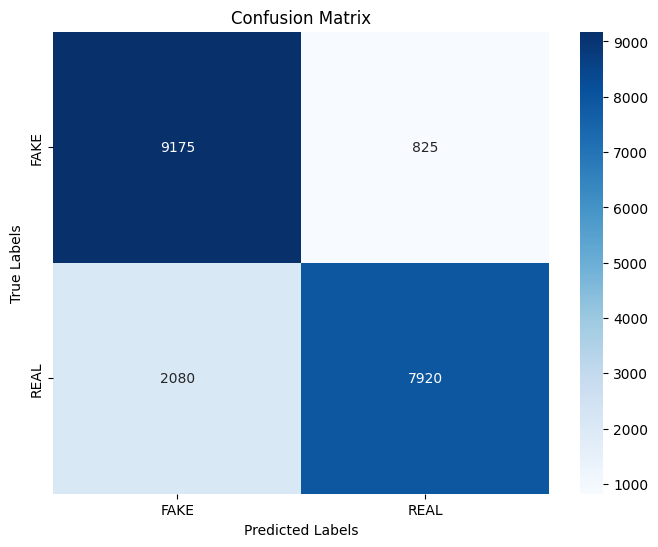

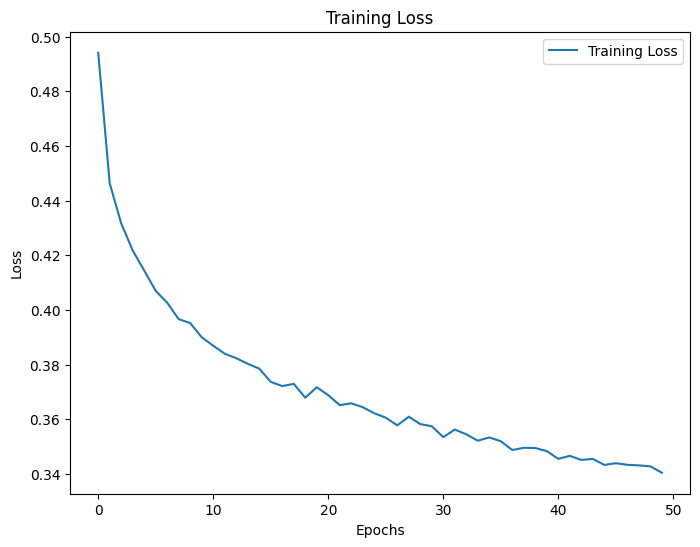

In [ ]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)



Accuracy: 0.85475


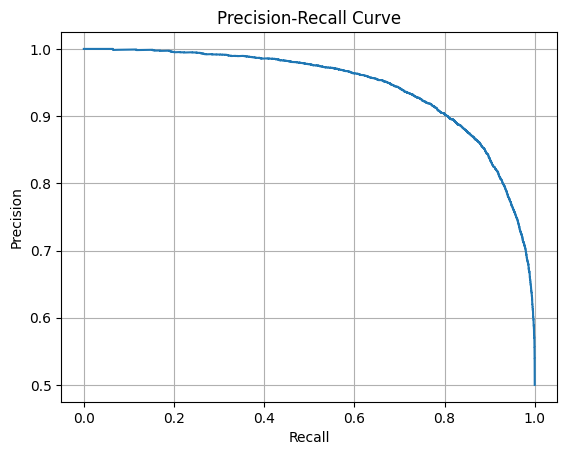

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(test_generator.labels, predictions)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

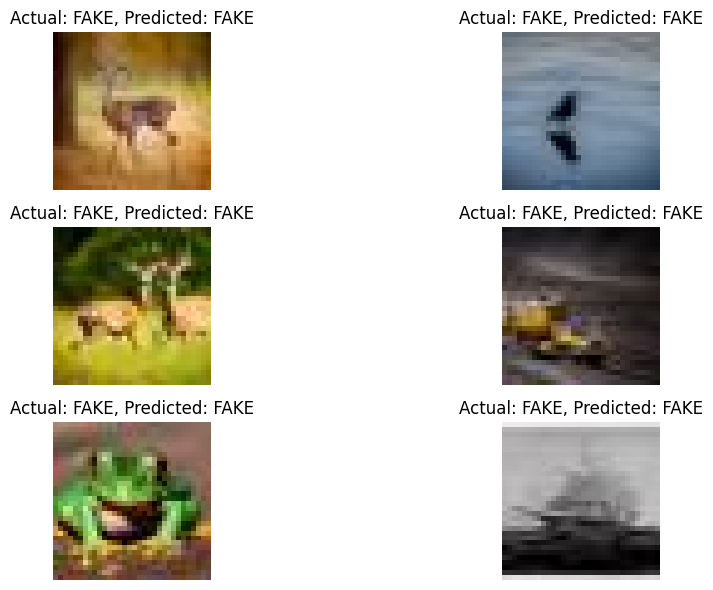

In [ ]:


# Select random samples from the test data
sample_indices = np.random.choice(len(test_generator), size=6, replace=False)
sample_images = []
sample_actual_labels = []
sample_predicted_labels = []
sample_probabilities = []

for i in sample_indices:
    image, actual_labels = test_generator[i]
    predicted_label = labels[i]
    probability = predictions[i][0]
    sample_images.append(image[0])  # Access the first image in the batch
    sample_actual_labels.append(actual_labels[0])  # Access the actual label for the first image
    sample_predicted_labels.append(predicted_label)
    sample_probabilities.append(probability)

# Calculate the subplot layout based on the number of sample images
num_images = len(sample_images)
num_rows = int(np.ceil(num_images / 2))
num_cols = min(num_images, 2)

# Plot the sample images with labels and probabilities
plt.figure(figsize=(12, 6))
for i in range(len(sample_images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(sample_images[i])
    actual_label = "FAKE" if sample_actual_labels[i] == 0 else "REAL"
    predicted_label = "FAKE" if sample_predicted_labels[i] == 0 else "REAL"
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


80134624/80134624 [==============================] - 5s 0us/step
Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Epoch 1/20
5000/5000 [==============================] - 141s 26ms/step - loss: 0.4995 - accuracy: 0.7552 - val_loss: 0.4446 - val_accuracy: 0.7957
Epoch 2/20
5000/5000 [==============================] - 118s 24ms/step - loss: 0.4535 - accuracy: 0.7874 - val_loss: 0.4264 - val_accuracy: 0.8058
Epoch 3/20
5000/5000 [==============================] - 122s 24ms/step - loss: 0.4382 - accuracy: 0.7954 - val_loss: 0.4022 - val_accuracy: 0.8203
Epoch 4/20
5000/5000 [==============================] - 120s 24ms/step - loss: 0.4274 - accuracy: 0.8033 - val_loss: 0.4188 - val_accuracy: 0.8094
Epoch 5/20
5000/5000 [==============================] - 122s 24ms/step - loss: 0.4201 - accuracy: 0.8080 - val_loss: 0.3848 - val_accuracy: 0.8322
Epoch 6/20
5000/5000 [==============================] - 130s 26ms/step - loss: 0.4145 - accuracy: 0.8106 - val_los

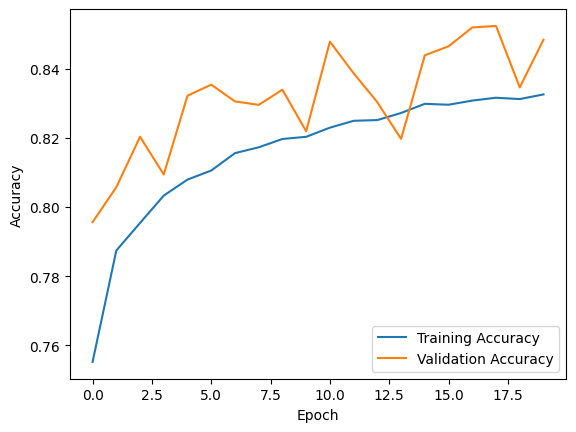

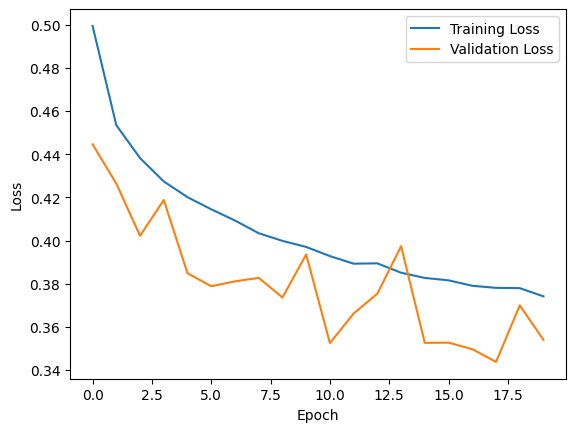

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score

# Set the paths to the train and test directories
train_dir = "/content/train"
test_dir = "/content/test"

# Create a validation directory and set its path
validation_dir = "/content/validation"
os.makedirs(validation_dir, exist_ok=True)

# Split the data into train and validation directories (e.g., 80% train and 20% validation)
split_ratio = 0.8
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    num_files = len(os.listdir(class_path))
    num_train = int(split_ratio * num_files)
    train_files = os.listdir(class_path)[:num_train]
    validation_files = os.listdir(class_path)[num_train:]

    # Move validation files to the validation directory
    for file_name in validation_files:
        src = os.path.join(class_path, file_name)
        dst = os.path.join(validation_dir, class_name, file_name)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.rename(src, dst)

# Set up the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size = 16

# Compile the model
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Perform data augmentation for validation data (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary'
)

# Load the validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary'
)

# Train the model with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size,
    verbose=1  # Set verbose to 1 to see training progress
)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

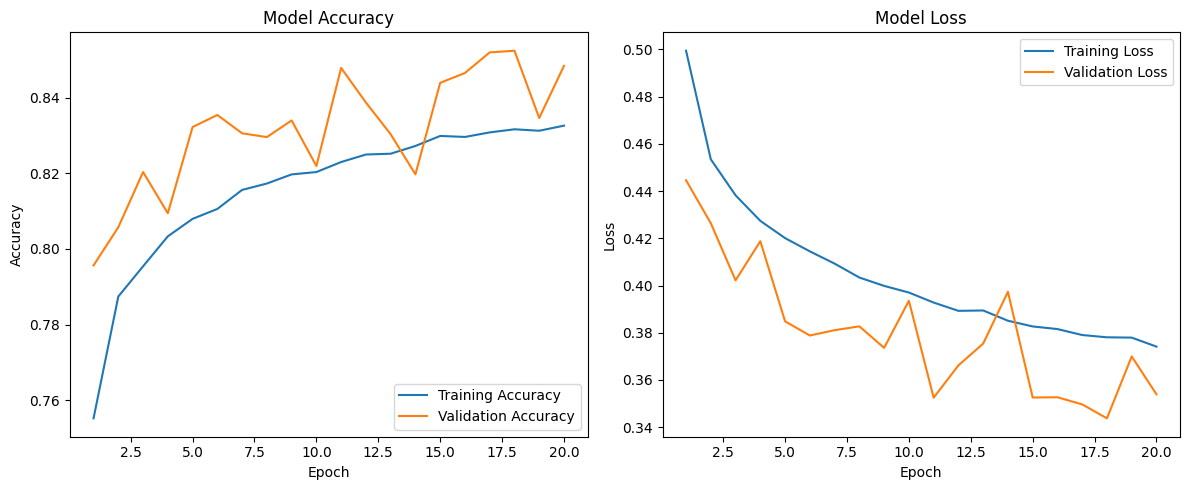

In [ ]:
import matplotlib.pyplot as plt


# Create a list of epochs from 1 to 20
epochs = range(1, 21)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


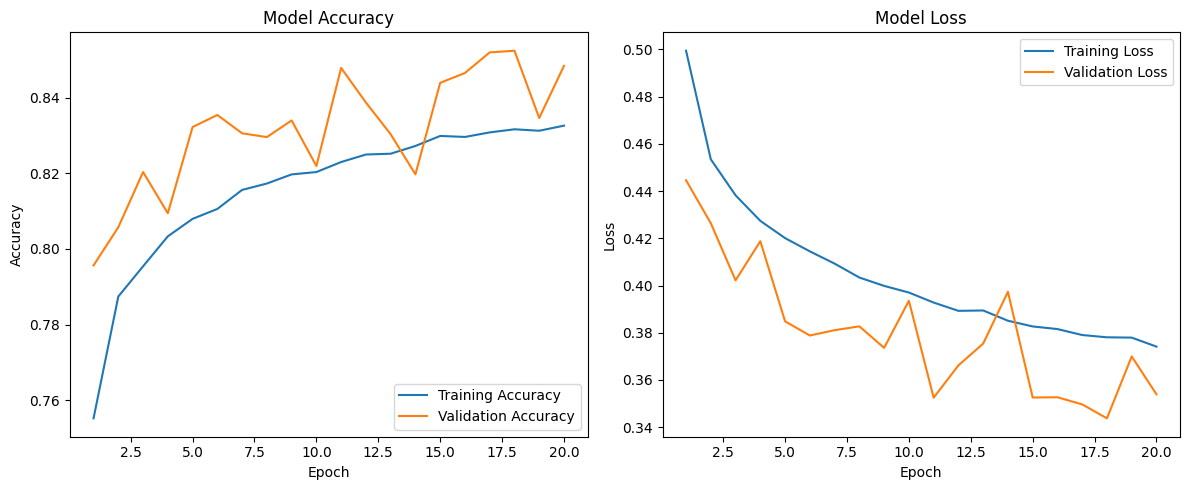

In [ ]:
import matplotlib.pyplot as plt


# Create a list of integer epochs from 1 to 20
epochs = list(range(1, 21))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
